In [1]:
import warnings
warnings.filterwarnings('ignore')
import re
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.metrics import Precision, Recall
import gradio as gr                                     
from Constants import *

In [2]:
train.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [3]:
test.head()

,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine


In [4]:
train = train.drop_duplicates(subset = ["SentenceId"], keep ="first")

In [5]:
test = test.drop_duplicates(subset = ["SentenceId"], keep ="first")

In [6]:
train.iloc[0]

PhraseId                                                      1
SentenceId                                                    1
Phrase        A series of escapades demonstrating the adage ...
Sentiment                                                     1
Name: 0, dtype: object

In [7]:
#train["Sentiment"].value_counts().plot(kind = "bar")

Sentiments values are;
- 0 : Negative
- 1 : Somewhat Negative
- 2 : Neutral
- 3 : Somewhat Positive
- 4 : Positive

In [7]:
train[train.columns[3:]].iloc[:]

,Sentiment
0,1
63,4
81,1
116,3
156,1
...,...
155984,2
155997,2
156021,1
156031,1


In [8]:
train.columns

Index(['PhraseId', 'SentenceId', 'Phrase', 'Sentiment'], dtype='object')

In [9]:
num_classes = len(train["Sentiment"].unique())
print(train["Sentiment"].unique())
print(num_classes)

[1 4 3 2 0]
5


In [10]:
X = train["Phrase"]
y = train[train.columns[3:]].values

In [11]:
def custom_standardisation(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_punct = tf.strings.regex_replace(lowercase, 
                                              "{~`!@$%^&*()_+"";..-=[;:/#.,\\t\n|?><']}",
                                         ' ')
    
    return tf.strings.regex_replace(stripped_punct,
                                    '[%s]' % re.escape(string.punctuation),
                                    '')

In [12]:
vectoriser = TextVectorization(
    standardize = custom_standardisation,
    max_tokens = MAX_FEATURES,
    output_sequence_length = SEQUENCE_LENGTH,
    output_mode = 'int'
)

In [13]:
vectoriser.adapt(X.values)

In [14]:
print(vectoriser.get_vocabulary()[2])
print(vectoriser.get_vocabulary()[200])
print(vectoriser.get_vocabulary()[1000])

the
seen
british


In [15]:
vectorised_text = vectoriser(X.values)
vectorised_text

<tf.Tensor: shape=(8529, 2000), dtype=int64, numpy=
array([[   3,  309,    5, ...,    0,    0,    0],
       [  17,  610, 4912, ...,    0,    0,    0],
       [  61,  286,    5, ...,    0,    0,    0],
       ...,
       [  44,  439,   43, ...,    0,    0,    0],
       [   2,   18,    8, ...,    0,    0,    0],
       [   2,   14,    7, ...,    0,    0,    0]], dtype=int64)>

In [16]:
dataset = tf.data.Dataset.from_tensor_slices((vectorised_text, y))
dataset = dataset.cache().shuffle(160000).batch(16).prefetch(8)

In [17]:
train_set = dataset.take(int(len(dataset) * 0.7))
val_set = dataset.skip(int(len(dataset) * 0.7)).take(int(len(dataset) * 0.2))
test_set = dataset.skip(int(len(dataset) * 0.9)).take(int(len(dataset) * 0.1))

In [23]:
model = keras.Sequential([
    layers.Embedding(MAX_FEATURES + 1, 32),
    layers.Bidirectional(layers.LSTM(32, activation = 'tanh')),
    layers.Dense(128, activation = 'relu'),
    layers.Dropout(0.25),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(num_classes, activation = 'softmax')
])

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          320032    
                                                                 
 bidirectional (Bidirection  (None, 64)                16640     
 al)                                                             
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 5)                 325       
                                                        

In [25]:
model.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy',
    metrics = ["accuracy"]
)

In [26]:
#tensorboard = Tensorboard(log_dir = "logs/{}".format(time()))

In [27]:
history = model.fit(train_set,
                    validation_data = val_set,
                    batch_size = BATCH_SIZE,
                    verbose = 1,
                    #callbacks = [tensorboard],
                    epochs = 30)

Epoch 1/30

373/373 [==============================] - 396s 1s/step - loss: 1.5650 - accuracy: 0.2793 - val_loss: 1.4608 - val_accuracy: 0.3726
Epoch 2/30
373/373 [==============================] - 377s 1s/step - loss: 1.3549 - accuracy: 0.4070 - val_loss: 1.1608 - val_accuracy: 0.4876
Epoch 3/30
373/373 [==============================] - 365s 979ms/step - loss: 1.1530 - accuracy: 0.5092 - val_loss: 1.0013 - val_accuracy: 0.6221
Epoch 4/30
373/373 [==============================] - 359s 962ms/step - loss: 0.9916 - accuracy: 0.5997 - val_loss: 0.7903 - val_accuracy: 0.6928
Epoch 5/30
373/373 [==============================] - 358s 959ms/step - loss: 0.8712 - accuracy: 0.6493 - val_loss: 0.7156 - val_accuracy: 0.7358
Epoch 6/30
373/373 [==============================] - 365s 979ms/step - loss: 0.7410 - accuracy: 0.7195 - val_loss: 0.6012 - val_accuracy: 0.7877
Epoch 7/30
373/373 [==============================] - 367s 984ms/step - loss: 0.6428 - accuracy: 0.7634 - val_loss: 0.4796 - val_

In [28]:
model.evaluate(test_set)

53/53 [==============================] - 8s 157ms/step - loss: 0.0461 - accuracy: 0.9882


[0.046119242906570435, 0.9882075190544128]

In [30]:
history = history.history

In [40]:
val_loss = history['val_loss']
loss = history['loss']

val_accuracy = history["val_accuracy"]
accuracy = history["accuracy"]

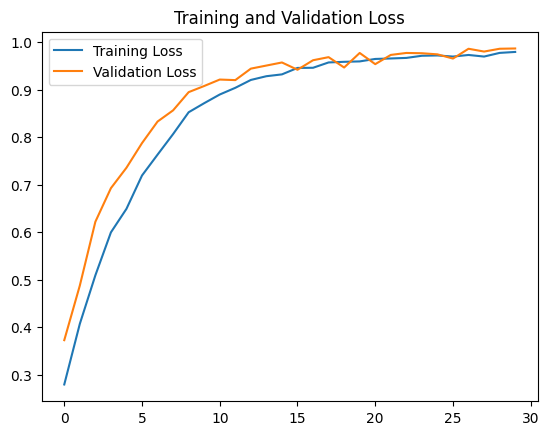

In [42]:
plt.plot(accuracy, label = "Training Accuracy")
plt.plot(val_accuracy, label = "Validation Accuracy")
plt.legend(loc = 'upper left')
plt.title("Training and Validation Accuracy")
plt.show()

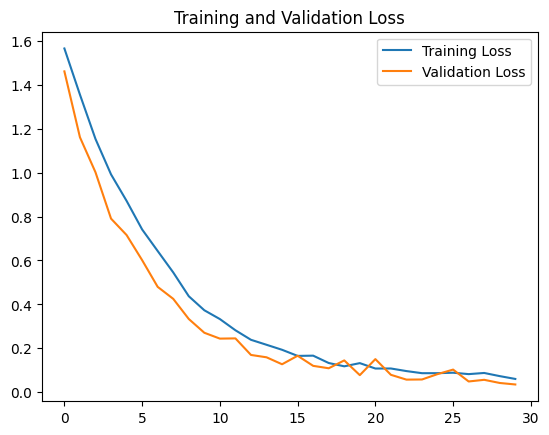

In [32]:
plt.plot(loss, label = "Training Loss")
plt.plot(val_loss, label = "Validation Loss")
plt.legend(loc = 'upper right')
plt.title("Training and Validation Loss")
plt.show()

In [33]:
model.save("movie_reviews.h5")

In [19]:
model = tf.keras.models.load_model("movie_reviews.h5")

In [20]:
sample_text = vectoriser("Subpar writing and bad scenes, this movie can certainly be improved")

In [26]:
result = model.predict(np.expand_dims(sample_text, 0))
result#.max()

1/1 [==============================] - 0s 153ms/step


array([[1.7468819e-04, 9.9443251e-01, 5.3047021e-03, 8.7931607e-05,
        1.8907659e-07]], dtype=float32)

In [27]:
train.columns[3:]

Index(['Sentiment'], dtype='object')

In [31]:
def score_comment(comment):
    vectorised_comment = vectoriser([comment])
    result = model.predict(vectorised_comment)
    
    text = ''
    for idx, col in enumerate(train.columns[3:]):
        text += "{} : {}\n".format(col, result[0][idx] > 0.5)
        
    return text

In [32]:
interface = gr.Interface(
    score_comment,
    gr.Textbox(lines = 3, placeholder = "Movie Review"),
    "text"
)

In [33]:
interface.launch(share = True)

Running on local URL:  http://127.0.0.1:7861

Could not create share link. Please check your internet connection or our status page: https://status.gradio.app.


1/1 [==============================] - 0s 140ms/step


In [ ]:
# Try find code on how to run prediction on array of comments
# find a way to create a dataframe for just the target sentiments with 1 for true targets and zero for false targets